This notebook is to reorganize our merged dataset on census tract level, which will be used for linear regression model.

* Aggregate accidents to the census tract level
    * This way, we can say whether or not accidents are going down within a geographic zone rather than just looking at trends on the accident level
    * Join each accident to its corresponding census tract
    * Then groupby the census tracts and sum all the columns
    * If the 'in safezone' column is greater than 0, then we know that at least one accident in that census tract occurred within a safe zone

In [1]:
import pandas as pd
import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.api as sma
import geopandas as gpd
import pylab as pl
import matplotlib.pylab as plt
import shapely
import seaborn as sns
import json
import fiona
import urllib
import urllib.request
import requests
from fiona.crs import from_epsg
import numpy as np
pd.set_option('display.max_columns', 500)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Add spfa into dataset

In [2]:
merged = pd.read_csv('data/cleanData/mergedClean.csv')
merged.head()

,ST_CASE_YEAR,SENIOR,S_PED,S_NOT_PED,S_PED_DEAD,S_SURVIVED,S_DEAD,S_DRINKING+,S_DRINKING-,S_MALE,S_FEMALE,S_DRUG+,S_DRUG-,S_DEAD_AFTER,S_DEAD_SCENE,S_DEAD_ROUTE,YOUNG,Y_PED,Y_NOT_PED,Y_SURVIVED,Y_DEAD,Y_PED_DEAD,Y_DRINKING+,Y_DRINKING-,Y_MALE,Y_FEMALE,Y_DRUG+,Y_DRUG-,Y_DEAD_AFTER,Y_DEAD_SCENE,Y_DEAD_ROUTE,ALIGNMNT,ARR_HOUR,ARR_MIN,CF1,CF2,CF3,CITY,COUNTY,C_M_ZONE,DAY,DAY_WEEK,DRUNK_DR,FATALS,FUNC_SYS,HARM_EV,HIT_RUN,HOSP_HR,HOSP_MN,HOUR,LATITUDE,LGT_COND,LONGITUD,MAN_COLL,MILEPT,MINUTE,MONTH,NHS,NOT_HOUR,NOT_MIN,NO_LANES,PAVE_TYP,PEDS,PERMVIT,PERNOTMVIT,PERSONS,PROFILE,PVH_INVL,RAIL,RD_OWNER,RELJCT1,RELJCT2,REL_JUNC,REL_ROAD,ROAD_FNC,ROUTE,RUR_URB,SCH_BUS,SP_JUR,SP_LIMIT,STATE,ST_CASE,SUR_COND,TRAF_FLO,TRA_CONT,TWAY_ID,TWAY_ID2,TYP_INT,T_CONT_F,VE_FORMS,VE_TOTAL,WEATHER,WEATHER1,WEATHER2,WRK_ZONE,YEAR
0,360075_2001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,2.0,1.0,0.0,2.0,1.0,1.0,0.0,2.0,2.0,0.0,0.0,1.0,99.0,99.0,0.0,0.0,0.0,4170.0,81.0,0.0,19.0,6.0,0.0,1.0,NaN,8.0,0.0,99.0,99.0,7.0,40.690725,1.0,-73.726761,0.0,8.0,30.0,1.0,1.0,99.0,99.0,4.0,2.0,1.0,NaN,NaN,2.0,1.0,NaN,0,NaN,NaN,NaN,2.0,1.0,12.0,8.0,NaN,0.0,0.0,99.0,36.0,360075,2.0,1.0,3.0,907A,NaN,NaN,3.0,1.0,NaN,2.0,NaN,NaN,NaN,2001
1,360091_2001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,2.0,1.0,0.0,2.0,2.0,0.0,0.0,2.0,2.0,0.0,0.0,1.0,99.0,99.0,0.0,0.0,0.0,4170.0,47.0,0.0,15.0,2.0,1.0,1.0,NaN,8.0,0.0,99.0,99.0,18.0,NaN,3.0,NaN,0.0,0.0,0.0,1.0,0.0,99.0,99.0,4.0,2.0,1.0,NaN,NaN,2.0,1.0,NaN,0,NaN,NaN,NaN,1.0,1.0,13.0,6.0,NaN,0.0,0.0,30.0,36.0,360091,1.0,1.0,0.0,CONEY ISLAND AVE,NaN,NaN,0.0,1.0,NaN,1.0,NaN,NaN,NaN,2001
2,360094_2001,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,2.0,0.0,0.0,1.0,99.0,99.0,0.0,0.0,0.0,4170.0,47.0,0.0,25.0,5.0,0.0,1.0,NaN,8.0,0.0,99.0,99.0,18.0,NaN,5.0,NaN,0.0,0.0,5.0,1.0,0.0,99.0,99.0,4.0,2.0,1.0,NaN,NaN,3.0,1.0,NaN,0,NaN,NaN,NaN,2.0,1.0,13.0,6.0,NaN,0.0,0.0,30.0,36.0,360094,1.0,1.0,3.0,3 AVE.,NaN,NaN,3.0,1.0,NaN,1.0,NaN,NaN,NaN,2001
3,360117_2001,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,2.0,1.0,0.0,3.0,2.0,0.0,2.0,3.0,0.0,0.0,2.0,1.0,2.0,0.0,1.0,99.0,99.0,0.0,0.0,0.0,4170.0,5.0,0.0,12.0,6.0,3.0,2.0,NaN,14.0,2.0,99.0,99.0,16.0,40.833542,1.0,-73.926067,0.0,0.0,15.0,1.0,0.0,99.0,99.0,2.0,2.0,2.0,NaN,NaN,4.0,2.0,NaN,0,NaN,NaN,NaN,3.0,7.0,16.0,6.0,NaN,0.0,0.0,99.0,36.0,360117,1.0,1.0,3.0,W-165TH ST,NaN,NaN,3.0,1.0,NaN,1.0,NaN,NaN,NaN,2001
4,360118_2001,3.0,1.0,2.0,1.0,0.0,3.0,0.0,1.0,3.0,0.0,0.0,1.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,99.0,99.0,0.0,0.0,0.0,4170.0,61.0,0.0,18.0,5.0,1.0,1.0,NaN,8.0,0.0,99.0,99.0,16.0,40.832786,5.0,-73.945856,0.0,0.0,32.0,1.0,0.0,99.0,99.0,4.0,2.0,1.0,NaN,NaN,4.0,2.0,NaN,0,NaN,NaN,NaN,2.0,1.0,13.0,6.0,NaN,0.0,0.0,99.0,36.0,360118,2.0,1.0,3.0,BROADWAY,NaN,NaN,3.0,1.0,NaN,2.0,NaN,NaN,NaN,2001


In [3]:
merged.dropna(subset=['LONGITUD', 'LATITUDE'], inplace=True)

In [4]:
merged.columns

Index(['ST_CASE_YEAR', 'SENIOR', 'S_PED', 'S_NOT_PED', 'S_PED_DEAD',
       'S_SURVIVED', 'S_DEAD', 'S_DRINKING+', 'S_DRINKING-', 'S_MALE',
       'S_FEMALE', 'S_DRUG+', 'S_DRUG-', 'S_DEAD_AFTER', 'S_DEAD_SCENE',
       'S_DEAD_ROUTE', 'YOUNG', 'Y_PED', 'Y_NOT_PED', 'Y_SURVIVED', 'Y_DEAD',
       'Y_PED_DEAD', 'Y_DRINKING+', 'Y_DRINKING-', 'Y_MALE', 'Y_FEMALE',
       'Y_DRUG+', 'Y_DRUG-', 'Y_DEAD_AFTER', 'Y_DEAD_SCENE', 'Y_DEAD_ROUTE',
       'ALIGNMNT', 'ARR_HOUR', 'ARR_MIN', 'CF1', 'CF2', 'CF3', 'CITY',
       'COUNTY', 'C_M_ZONE', 'DAY', 'DAY_WEEK', 'DRUNK_DR', 'FATALS',
       'FUNC_SYS', 'HARM_EV', 'HIT_RUN', 'HOSP_HR', 'HOSP_MN', 'HOUR',
       'LATITUDE', 'LGT_COND', 'LONGITUD', 'MAN_COLL', 'MILEPT', 'MINUTE',
       'MONTH', 'NHS', 'NOT_HOUR', 'NOT_MIN', 'NO_LANES', 'PAVE_TYP', 'PEDS',
       'PERMVIT', 'PERNOTMVIT', 'PERSONS', 'PROFILE', 'PVH_INVL', 'RAIL',
       'RD_OWNER', 'RELJCT1', 'RELJCT2', 'REL_JUNC', 'REL_ROAD', 'ROAD_FNC',
       'ROUTE', 'RUR_URB', 'SCH_BUS', 'SP_J

In [5]:
merged = merged[['ST_CASE_YEAR','YEAR', 'SENIOR', 'S_PED', 'S_NOT_PED', 'S_PED_DEAD',
       'S_SURVIVED', 'S_DEAD', 'S_DRINKING+', 'S_DRINKING-', 'S_MALE',
       'S_FEMALE', 'S_DRUG+', 'S_DRUG-', 'S_DEAD_AFTER', 'S_DEAD_SCENE',
       'S_DEAD_ROUTE', 'YOUNG', 'Y_PED', 'Y_NOT_PED', 'Y_SURVIVED',
       'Y_DEAD', 'Y_PED_DEAD', 'Y_DRINKING+', 'Y_DRINKING-', 'Y_MALE',
       'Y_FEMALE', 'Y_DRUG+', 'Y_DRUG-', 'Y_DEAD_AFTER', 'Y_DEAD_SCENE',
       'Y_DEAD_ROUTE','FATALS','LGT_COND','WEATHER','LONGITUD', 'LATITUDE','DAY_WEEK','MONTH','HOUR','DAY']]

In [6]:
merged.shape

(2445, 41)

In [7]:
merged = pd.get_dummies(merged,columns = ['WEATHER'])
merged = pd.get_dummies(merged,columns = ['LGT_COND'])

In [8]:
merged = pd.get_dummies(merged,columns = ['DAY_WEEK'])
merged = pd.get_dummies(merged,columns = ['MONTH'])
merged = pd.get_dummies(merged,columns = ['HOUR'])
merged = pd.get_dummies(merged,columns = ['DAY'])

In [9]:
merged.columns.values

array(['ST_CASE_YEAR', 'YEAR', 'SENIOR', 'S_PED', 'S_NOT_PED',
       'S_PED_DEAD', 'S_SURVIVED', 'S_DEAD', 'S_DRINKING+', 'S_DRINKING-',
       'S_MALE', 'S_FEMALE', 'S_DRUG+', 'S_DRUG-', 'S_DEAD_AFTER',
       'S_DEAD_SCENE', 'S_DEAD_ROUTE', 'YOUNG', 'Y_PED', 'Y_NOT_PED',
       'Y_SURVIVED', 'Y_DEAD', 'Y_PED_DEAD', 'Y_DRINKING+', 'Y_DRINKING-',
       'Y_MALE', 'Y_FEMALE', 'Y_DRUG+', 'Y_DRUG-', 'Y_DEAD_AFTER',
       'Y_DEAD_SCENE', 'Y_DEAD_ROUTE', 'FATALS', 'LONGITUD', 'LATITUDE',
       'WEATHER_1.0', 'WEATHER_2.0', 'WEATHER_3.0', 'WEATHER_4.0',
       'WEATHER_5.0', 'WEATHER_9.0', 'WEATHER_10.0', 'WEATHER_98.0',
       'WEATHER_99.0', 'LGT_COND_1.0', 'LGT_COND_2.0', 'LGT_COND_3.0',
       'LGT_COND_4.0', 'LGT_COND_5.0', 'LGT_COND_6.0', 'LGT_COND_9.0',
       'DAY_WEEK_1.0', 'DAY_WEEK_2.0', 'DAY_WEEK_3.0', 'DAY_WEEK_4.0',
       'DAY_WEEK_5.0', 'DAY_WEEK_6.0', 'DAY_WEEK_7.0', 'MONTH_1.0',
       'MONTH_2.0', 'MONTH_3.0', 'MONTH_4.0', 'MONTH_5.0', 'MONTH_6.0',
       'MONTH_7.0', '

In [10]:
merged['WEEKDAY'] = merged['DAY_WEEK_2.0']+merged['DAY_WEEK_3.0']+merged['DAY_WEEK_4.0']+merged['DAY_WEEK_5.0']+merged['DAY_WEEK_6.0']
merged['WEEKEND'] = merged['DAY_WEEK_1.0']+merged['DAY_WEEK_7.0']
merged['MONTH_Q1'] = merged['MONTH_1.0']+merged['MONTH_2.0']+merged['MONTH_3.0']
merged['MONTH_Q2'] = merged['MONTH_4.0']+merged['MONTH_5.0']+merged['MONTH_6.0']
merged['MONTH_Q3'] = merged['MONTH_7.0']+merged['MONTH_8.0']+merged['MONTH_9.0']
merged['MONTH_Q4'] = merged['MONTH_10.0']+merged['MONTH_11.0']+merged['MONTH_12.0']
merged['MORNING'] = merged['HOUR_6.0']+merged['HOUR_7.0']+merged['HOUR_8.0']+merged['HOUR_9.0']+merged['HOUR_10.0']+merged['HOUR_11.0']
merged['NOON'] = merged['HOUR_12.0']+merged['HOUR_13.0']+merged['HOUR_14.0']
merged['AFTERNOON'] = merged['HOUR_15.0']+merged['HOUR_16.0']+merged['HOUR_17.0']+merged['HOUR_18.0']+merged['HOUR_19.0']
merged['NIGHT'] = merged['HOUR_20.0']+merged['HOUR_21.0']+merged['HOUR_22.0']+merged['HOUR_23.0']
merged['MIDNIGHT'] = merged['HOUR_0.0']+merged['HOUR_1.0']+merged['HOUR_2.0']+merged['HOUR_3.0']+merged['HOUR_4.0']+merged['HOUR_5.0']

In [11]:
merged['MONTH_1'] = merged['DAY_1.0']+merged['DAY_2.0']+merged['DAY_3.0']+merged['DAY_4.0']+merged['DAY_5.0']+merged['DAY_6.0']+merged['DAY_7.0']+merged['DAY_8.0']+merged['DAY_9.0']+merged['DAY_10.0']
merged['MONTH_2'] = merged['DAY_11.0']+merged['DAY_12.0']+merged['DAY_13.0']+merged['DAY_14.0']+merged['DAY_15.0']+merged['DAY_16.0']+merged['DAY_17.0']+merged['DAY_18.0']+merged['DAY_19.0']+merged['DAY_20.0']
merged['MONTH_3'] = merged['DAY_21.0']+merged['DAY_22.0']+merged['DAY_23.0']+merged['DAY_24.0']+merged['DAY_25.0']+merged['DAY_26.0']+merged['DAY_27.0']+merged['DAY_28.0']+merged['DAY_29.0']+merged['DAY_30.0']+merged['DAY_31.0']

In [12]:
merged.drop({"WEATHER_9.0","WEATHER_98.0","WEATHER_99.0","LGT_COND_9.0",
            'DAY_WEEK_1.0', 'DAY_WEEK_2.0', 'DAY_WEEK_3.0', 'DAY_WEEK_4.0',
       'DAY_WEEK_5.0', 'DAY_WEEK_6.0', 'DAY_WEEK_7.0',
            'MONTH_1.0',
       'MONTH_2.0', 'MONTH_3.0', 'MONTH_4.0', 'MONTH_5.0', 'MONTH_6.0',
       'MONTH_7.0', 'MONTH_8.0', 'MONTH_9.0', 'MONTH_10.0', 'MONTH_11.0',
       'MONTH_12.0','HOUR_0.0', 'HOUR_1.0', 'HOUR_2.0', 'HOUR_3.0',
       'HOUR_4.0', 'HOUR_5.0', 'HOUR_6.0', 'HOUR_7.0', 'HOUR_8.0',
       'HOUR_9.0', 'HOUR_10.0', 'HOUR_11.0', 'HOUR_12.0', 'HOUR_13.0',
       'HOUR_14.0', 'HOUR_15.0', 'HOUR_16.0', 'HOUR_17.0', 'HOUR_18.0',
       'HOUR_19.0', 'HOUR_20.0', 'HOUR_21.0', 'HOUR_22.0', 'HOUR_23.0',
       'HOUR_99.0','DAY_1.0', 'DAY_2.0', 'DAY_3.0', 'DAY_4.0', 'DAY_5.0',
       'DAY_6.0', 'DAY_7.0', 'DAY_8.0', 'DAY_9.0', 'DAY_10.0', 'DAY_11.0',
       'DAY_12.0', 'DAY_13.0', 'DAY_14.0', 'DAY_15.0', 'DAY_16.0',
       'DAY_17.0', 'DAY_18.0', 'DAY_19.0', 'DAY_20.0', 'DAY_21.0',
       'DAY_22.0', 'DAY_23.0', 'DAY_24.0', 'DAY_25.0', 'DAY_26.0',
       'DAY_27.0', 'DAY_28.0', 'DAY_29.0', 'DAY_30.0', 'DAY_31.0'},axis=1,inplace=True)
merged.rename(columns = {"WEATHER_1.0":"WEATHER_GOOD","WEATHER_2.0":"WEATHER_RAIN","WEATHER_3.0":"WEATHER_SLEET",
                         "WEATHER_4.0":"WEATHER_SNOW","WEATHER_5.0":"WEATHER_FOG","WEATHER_10.0":"WEATHER_CLOUDY",
                         "LGT_COND_1.0":"LGT_COND_DAYLIGHT","LGT_COND_2.0":"LGT_COND_DARK_NOT_LIGHTED",
                         "LGT_COND_3.0":"LGT_COND_DARK_LIGHTED","LGT_COND_4.0":"LGT_COND_DAWN",
                         "LGT_COND_5.0":"LGT_COND_DUSK","LGT_COND_6.0":"LGT_COND_DARK_UNKNOWN_LIGHTING"},inplace=True)

In [13]:
merged.head()

,ST_CASE_YEAR,YEAR,SENIOR,S_PED,S_NOT_PED,S_PED_DEAD,S_SURVIVED,S_DEAD,S_DRINKING+,S_DRINKING-,S_MALE,S_FEMALE,S_DRUG+,S_DRUG-,S_DEAD_AFTER,S_DEAD_SCENE,S_DEAD_ROUTE,YOUNG,Y_PED,Y_NOT_PED,Y_SURVIVED,Y_DEAD,Y_PED_DEAD,Y_DRINKING+,Y_DRINKING-,Y_MALE,Y_FEMALE,Y_DRUG+,Y_DRUG-,Y_DEAD_AFTER,Y_DEAD_SCENE,Y_DEAD_ROUTE,FATALS,LONGITUD,LATITUDE,WEATHER_GOOD,WEATHER_RAIN,WEATHER_SLEET,WEATHER_SNOW,WEATHER_FOG,WEATHER_CLOUDY,LGT_COND_DAYLIGHT,LGT_COND_DARK_NOT_LIGHTED,LGT_COND_DARK_LIGHTED,LGT_COND_DAWN,LGT_COND_DUSK,LGT_COND_DARK_UNKNOWN_LIGHTING,WEEKDAY,WEEKEND,MONTH_Q1,MONTH_Q2,MONTH_Q3,MONTH_Q4,MORNING,NOON,AFTERNOON,NIGHT,MIDNIGHT,MONTH_1,MONTH_2,MONTH_3
0,360075_2001,2001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,2.0,1.0,0.0,2.0,1.0,1.0,0.0,2.0,2.0,0.0,0.0,1.0,-73.726761,40.690725,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,360117_2001,2001,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,2.0,1.0,0.0,3.0,2.0,0.0,2.0,3.0,0.0,0.0,2.0,1.0,2.0,0.0,2.0,-73.926067,40.833542,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,360118_2001,2001,3.0,1.0,2.0,1.0,0.0,3.0,0.0,1.0,3.0,0.0,0.0,1.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,-73.945856,40.832786,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5,360145_2001,2001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,2.0,1.0,0.0,2.0,1.0,1.0,0.0,2.0,1.0,1.0,0.0,1.0,-73.952425,40.650719,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
6,360150_2001,2001,2.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,1.0,1.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,-73.817803,40.681522,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [14]:
merged.shape

(2445, 61)

In [15]:
merged['lonlat'] = list(zip(merged.LONGITUD, merged.LATITUDE))
merged['geometry'] = merged[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
merged = gpd.GeoDataFrame(merged)

In [16]:
merged.crs = from_epsg(4326)
merged.to_crs(epsg=4326, inplace = True)

In [17]:
merged.columns.values

array(['ST_CASE_YEAR', 'YEAR', 'SENIOR', 'S_PED', 'S_NOT_PED',
       'S_PED_DEAD', 'S_SURVIVED', 'S_DEAD', 'S_DRINKING+', 'S_DRINKING-',
       'S_MALE', 'S_FEMALE', 'S_DRUG+', 'S_DRUG-', 'S_DEAD_AFTER',
       'S_DEAD_SCENE', 'S_DEAD_ROUTE', 'YOUNG', 'Y_PED', 'Y_NOT_PED',
       'Y_SURVIVED', 'Y_DEAD', 'Y_PED_DEAD', 'Y_DRINKING+', 'Y_DRINKING-',
       'Y_MALE', 'Y_FEMALE', 'Y_DRUG+', 'Y_DRUG-', 'Y_DEAD_AFTER',
       'Y_DEAD_SCENE', 'Y_DEAD_ROUTE', 'FATALS', 'LONGITUD', 'LATITUDE',
       'WEATHER_GOOD', 'WEATHER_RAIN', 'WEATHER_SLEET', 'WEATHER_SNOW',
       'WEATHER_FOG', 'WEATHER_CLOUDY', 'LGT_COND_DAYLIGHT',
       'LGT_COND_DARK_NOT_LIGHTED', 'LGT_COND_DARK_LIGHTED',
       'LGT_COND_DAWN', 'LGT_COND_DUSK', 'LGT_COND_DARK_UNKNOWN_LIGHTING',
       'WEEKDAY', 'WEEKEND', 'MONTH_Q1', 'MONTH_Q2', 'MONTH_Q3',
       'MONTH_Q4', 'MORNING', 'NOON', 'AFTERNOON', 'NIGHT', 'MIDNIGHT',
       'MONTH_1', 'MONTH_2', 'MONTH_3', 'lonlat', 'geometry'], dtype=object)

In [18]:
spfa = gpd.GeoDataFrame.from_file('data/vizZeroSSfSshapefile/geo_export_39b3b39b-7a20-4454-8888-016d51d9ccaf.shp')
spfa.crs = from_epsg(4326)
spfa.to_crs(epsg=4326, inplace = True)

In [19]:
# To cover the largest batch of SPFA zones
spfa.insert(1, 'rounds', 1)

In [20]:
# Manually adding round label to specific zones after manual review
spfa.loc[0:2,'rounds'] = 2
spfa.loc[3, 'rounds'] = 3
spfa.loc[7, 'rounds'] = 3
spfa.loc[11, 'rounds'] = 3
spfa.loc[14:15, 'rounds'] = 2
spfa.loc[18, 'rounds'] = 2
spfa.loc[21, 'rounds'] = 3
spfa.loc[24:26, 'rounds'] = 2
spfa.loc[28:29, 'rounds'] = 2
spfa.loc[36, 'rounds'] = 2

In [21]:
spfa.reset_index(drop=True, inplace=True)
merged.reset_index(drop=True, inplace=True)

In [22]:
merged = gpd.tools.sjoin(merged,spfa,how='left')

In [23]:
merged.shape

(2445, 68)

In [24]:
spfa.shape

(41, 5)

In [25]:
merged.drop(['index_right', 'shape_area', 'shape_leng'], axis=1, inplace=True)
merged.reset_index(drop=True, inplace=True)

In [26]:
merged.shape

(2445, 65)

In [27]:
merged = pd.get_dummies(merged, columns=['rounds'])
merged.head()

,ST_CASE_YEAR,YEAR,SENIOR,S_PED,S_NOT_PED,S_PED_DEAD,S_SURVIVED,S_DEAD,S_DRINKING+,S_DRINKING-,S_MALE,S_FEMALE,S_DRUG+,S_DRUG-,S_DEAD_AFTER,S_DEAD_SCENE,S_DEAD_ROUTE,YOUNG,Y_PED,Y_NOT_PED,Y_SURVIVED,Y_DEAD,Y_PED_DEAD,Y_DRINKING+,Y_DRINKING-,Y_MALE,Y_FEMALE,Y_DRUG+,Y_DRUG-,Y_DEAD_AFTER,Y_DEAD_SCENE,Y_DEAD_ROUTE,FATALS,LONGITUD,LATITUDE,WEATHER_GOOD,WEATHER_RAIN,WEATHER_SLEET,WEATHER_SNOW,WEATHER_FOG,WEATHER_CLOUDY,LGT_COND_DAYLIGHT,LGT_COND_DARK_NOT_LIGHTED,LGT_COND_DARK_LIGHTED,LGT_COND_DAWN,LGT_COND_DUSK,LGT_COND_DARK_UNKNOWN_LIGHTING,WEEKDAY,WEEKEND,MONTH_Q1,MONTH_Q2,MONTH_Q3,MONTH_Q4,MORNING,NOON,AFTERNOON,NIGHT,MIDNIGHT,MONTH_1,MONTH_2,MONTH_3,lonlat,geometry,name,rounds_1.0,rounds_2.0,rounds_3.0
0,360075_2001,2001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,2.0,1.0,0.0,2.0,1.0,1.0,0.0,2.0,2.0,0.0,0.0,1.0,-73.726761,40.690725,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"(-73.72676111, 40.690725)",POINT (-73.72676111 40.690725),NaN,0.0,0.0,0.0
1,360117_2001,2001,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,2.0,1.0,0.0,3.0,2.0,0.0,2.0,3.0,0.0,0.0,2.0,1.0,2.0,0.0,2.0,-73.926067,40.833542,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,"(-73.92606667, 40.83354167)",POINT (-73.92606667 40.83354167),Highbridge/Lower Concourse,0.0,0.0,1.0
2,360118_2001,2001,3.0,1.0,2.0,1.0,0.0,3.0,0.0,1.0,3.0,0.0,0.0,1.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,-73.945856,40.832786,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,"(-73.94585556, 40.83278611)",POINT (-73.94585556 40.83278611),Hamilton Heights,1.0,0.0,0.0
3,360145_2001,2001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,2.0,1.0,0.0,2.0,1.0,1.0,0.0,2.0,1.0,1.0,0.0,1.0,-73.952425,40.650719,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,"(-73.952425, 40.65071944)",POINT (-73.95242500000001 40.65071944),Flatbush,0.0,1.0,0.0
4,360150_2001,2001,2.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,1.0,1.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,-73.817803,40.681522,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,"(-73.81780278, 40.68152222)",POINT (-73.81780277999999 40.68152222),NaN,0.0,0.0,0.0


In [82]:
merged.shape

(2445, 69)

In [28]:
for i in range(1,4):
    print("Total number of accidents that have occurred within round {} zones: {}".format(i, \
                                                                   merged['rounds_{}.0'.format(i)].sum()))

Total number of accidents that have occurred within round 1 zones: 241.0
Total number of accidents that have occurred within round 2 zones: 178.0
Total number of accidents that have occurred within round 3 zones: 138.0


In [29]:
"""
Create a separate column indicating whether or not each accident that occurred in an SPFA took place after the
SPFA was implemented (True indicates that it did occur in an SPFA after it was implemented)
"""
merged['acc_post_spfa'] = (((merged['rounds_1.0']==1) & (merged['YEAR']>=2008)) | \
                               ((merged['rounds_2.0']==1) & (merged['YEAR']>=2012)) | \
                               ((merged['rounds_3.0']==1) & (merged['YEAR']>=2017)))

In [30]:
"""
Create a column indicating whether or not an accident occurred within an SPFA or not (True indicates that it did 
occur in an SPFA)
"""
merged['name'] = merged['name'].astype(str)
merged['in_spfa'] = merged['name'] != 'nan'

In [31]:
merged['acc_post_spfa'] = merged['acc_post_spfa'].astype('int')
merged['in_spfa'] = merged['in_spfa'].astype('int')

In [32]:
print("Number of accidents that occurred within any SPFA zone after that SPFA zone was implemented: " + \
      str(np.count_nonzero(merged['acc_post_spfa'])))

Number of accidents that occurred within any SPFA zone after that SPFA zone was implemented: 186


In [33]:
merged['rounds_3.0'].unique()

array([ 0.,  1.])

# Add Census Tract

In [34]:
# url = "https://data.cityofnewyork.us/api/geospatial/fxpq-c8ku?method=export&format=Shapefile"
# urllib.request.urlretrieve(url, "file.gz")
# !unzip file.gz

In [37]:
ct = gpd.GeoDataFrame.from_file("data/ct2010/geo_export_a6d6dc16-49d8-49a3-8225-1a94b1493e81.shp")

In [38]:
ct.columns

Index(['boro_code', 'boro_ct201', 'boro_name', 'cdeligibil', 'ct2010',
       'ctlabel', 'ntacode', 'ntaname', 'puma', 'shape_area', 'shape_leng',
       'geometry'],
      dtype='object')

In [39]:
ct.head()

,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,geometry
0,5,5000900,Staten Island,E,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016794,POLYGON ((-74.07920577013245 40.64343078374567...
1,1,1009800,Manhattan,I,009800,98,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.199811,POLYGON ((-73.96432543478758 40.75638153099091...
2,1,1010000,Manhattan,I,010000,100,MN19,Turtle Bay-East Midtown,3808,1.860938e+06,5692.168737,POLYGON ((-73.96802436915851 40.75957814005282...
3,1,1010200,Manhattan,I,010200,102,MN17,Midtown-Midtown South,3807,1.860993e+06,5687.802439,POLYGON ((-73.97124277307127 40.76093641847906...
4,1,1010400,Manhattan,I,010400,104,MN17,Midtown-Midtown South,3807,1.864600e+06,5693.036367,POLYGON ((-73.97445730550224 40.76229308352487...


In [40]:
ct.shape

(2166, 12)

In [41]:
ct.crs = from_epsg(4326)
ct.to_crs(epsg=4326, inplace = True)

In [42]:
merged.shape

(2445, 69)

In [43]:
type(merged)

geopandas.geodataframe.GeoDataFrame

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


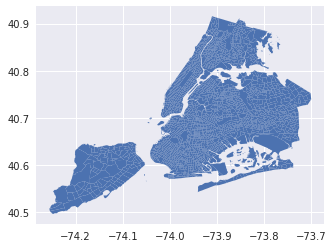

In [44]:
ct.plot()

In [45]:
ct_spfa = gpd.sjoin(merged,ct)
ct_spfa.shape

(2404, 81)

In [46]:
ct_spfa.ST_CASE_YEAR.nunique()

2404

In [47]:
ct_spfa.ct2010.nunique()

884

In [48]:
ct_spfa.puma.nunique()

55

In [49]:
ct_spfa.boro_ct201.nunique()

1227

In [50]:
ct_spfa.reset_index(inplace=True)

In [51]:
ct_spfa.drop('index',axis=1,inplace=True)
ct_spfa.head()

,ST_CASE_YEAR,YEAR,SENIOR,S_PED,S_NOT_PED,S_PED_DEAD,S_SURVIVED,S_DEAD,S_DRINKING+,S_DRINKING-,S_MALE,S_FEMALE,S_DRUG+,S_DRUG-,S_DEAD_AFTER,S_DEAD_SCENE,S_DEAD_ROUTE,YOUNG,Y_PED,Y_NOT_PED,Y_SURVIVED,Y_DEAD,Y_PED_DEAD,Y_DRINKING+,Y_DRINKING-,Y_MALE,Y_FEMALE,Y_DRUG+,Y_DRUG-,Y_DEAD_AFTER,Y_DEAD_SCENE,Y_DEAD_ROUTE,FATALS,LONGITUD,LATITUDE,WEATHER_GOOD,WEATHER_RAIN,WEATHER_SLEET,WEATHER_SNOW,WEATHER_FOG,WEATHER_CLOUDY,LGT_COND_DAYLIGHT,LGT_COND_DARK_NOT_LIGHTED,LGT_COND_DARK_LIGHTED,LGT_COND_DAWN,LGT_COND_DUSK,LGT_COND_DARK_UNKNOWN_LIGHTING,WEEKDAY,WEEKEND,MONTH_Q1,MONTH_Q2,MONTH_Q3,MONTH_Q4,MORNING,NOON,AFTERNOON,NIGHT,MIDNIGHT,MONTH_1,MONTH_2,MONTH_3,lonlat,geometry,name,rounds_1.0,rounds_2.0,rounds_3.0,acc_post_spfa,in_spfa,index_right,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng
0,360075_2001,2001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,2.0,1.0,0.0,2.0,1.0,1.0,0.0,2.0,2.0,0.0,0.0,1.0,-73.726761,40.690725,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"(-73.72676111, 40.690725)",POINT (-73.72676111 40.690725),nan,0.0,0.0,0.0,0,0,757,4,4062200,Queens,I,062200,622,QN33,Cambria Heights,4105,4.707929e+06,10230.983689
1,361127_2013,2013,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,-73.730556,40.691925,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,"(-73.73055556, 40.691925)",POINT (-73.73055556 40.691925),nan,0.0,0.0,0.0,0,0,757,4,4062200,Queens,I,062200,622,QN33,Cambria Heights,4105,4.707929e+06,10230.983689
2,360117_2001,2001,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,2.0,1.0,0.0,3.0,2.0,0.0,2.0,3.0,0.0,0.0,2.0,1.0,2.0,0.0,2.0,-73.926067,40.833542,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,"(-73.92606667, 40.83354167)",POINT (-73.92606667 40.83354167),Highbridge/Lower Concourse,0.0,0.0,1.0,0,1,1594,2,2019300,Bronx,E,019300,193,BX26,Highbridge,3708,2.587522e+06,9040.227903
3,361250_2002,2002,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,1.0,4.0,0.0,5.0,1.0,0.0,3.0,2.0,3.0,0.0,3.0,4.0,0.0,0.0,1.0,-73.930092,40.838114,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,"(-73.93009167, 40.83811389)",POINT (-73.93009167 40.83811389),nan,0.0,0.0,0.0,0,0,1594,2,2019300,Bronx,E,019300,193,BX26,Highbridge,3708,2.587522e+06,9040.227903
4,360118_2001,2001,3.0,1.0,2.0,1.0,0.0,3.0,0.0,1.0,3.0,0.0,0.0,1.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,-73.945856,40.832786,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,"(-73.94585556, 40.83278611)",POINT (-73.94585556 40.83278611),Hamilton Heights,1.0,0.0,0.0,0,1,1955,1,1024100,Manhattan,E,024100,241,MN36,Washington Heights South,3801,1.871813e+06,6496.571838


In [53]:
ct_spfa.shape

(2404, 81)

In [83]:
ct_spfa.describe()

,YEAR,SENIOR,S_PED,S_NOT_PED,S_PED_DEAD,S_SURVIVED,S_DEAD,S_DRINKING+,S_DRINKING-,S_MALE,S_FEMALE,S_DRUG+,S_DRUG-,S_DEAD_AFTER,S_DEAD_SCENE,S_DEAD_ROUTE,YOUNG,Y_PED,Y_NOT_PED,Y_SURVIVED,Y_DEAD,Y_PED_DEAD,Y_DRINKING+,Y_DRINKING-,Y_MALE,Y_FEMALE,Y_DRUG+,Y_DRUG-,Y_DEAD_AFTER,Y_DEAD_SCENE,Y_DEAD_ROUTE,FATALS,LONGITUD,LATITUDE,WEATHER_GOOD,WEATHER_RAIN,WEATHER_SLEET,WEATHER_SNOW,WEATHER_FOG,WEATHER_CLOUDY,LGT_COND_DAYLIGHT,LGT_COND_DARK_NOT_LIGHTED,LGT_COND_DARK_LIGHTED,LGT_COND_DAWN,LGT_COND_DUSK,LGT_COND_DARK_UNKNOWN_LIGHTING,WEEKDAY,WEEKEND,MONTH_Q1,MONTH_Q2,MONTH_Q3,MONTH_Q4,MORNING,NOON,AFTERNOON,NIGHT,MIDNIGHT,MONTH_1,MONTH_2,MONTH_3,rounds_1.0,rounds_2.0,rounds_3.0,acc_post_spfa,in_spfa,index_right,shape_area,shape_leng
count,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2404.000000,2.404000e+03,2404.000000
mean,2008.556572,0.664309,0.387271,0.277038,0.381032,0.136439,0.527870,0.006240,0.091098,0.298253,0.225874,0.001248,0.069884,0.596090,0.046173,0.017471,1.998752,0.740433,1.258319,0.659734,1.339018,0.681780,0.064476,0.349002,1.412230,0.584859,0.004576,0.242097,1.827787,0.129784,0.030366,1.018303,-73.926962,40.722380,0.801165,0.116473,0.004992,0.006656,0.000832,0.057820,0.458403,0.044509,0.442180,0.028702,0.024958,0.000832,0.732945,0.267055,0.233361,0.216306,0.233777,0.316556,0.220050,0.131448,0.260815,0.202995,0.183444,0.342346,0.316140,0.341514,0.100250,0.074043,0.057404,0.077371,0.231697,1199.906822,5.054067e+06,9947.158128
std,4.846512,0.729298,0.507313,0.550221,0.500094,0.401437,0.657595,0.078761,0.319338,0.526119,0.459038,0.035311,0.281382,0.716259,0.211877,0.131045,1.481330,0.776268,1.165566,1.144867,1.306965,0.648813,0.250681,0.894843,1.089518,0.928956,0.067503,0.689104,1.466891,0.354219,0.171628,0.190488,0.081859,0.084874,0.399207,0.320857,0.070490,0.081327,0.028837,0.233452,0.498370,0.206266,0.496749,0.167003,0.156031,0.028837,0.442513,0.442513,0.423058,0.411811,0.423320,0.465229,0.414366,0.337960,0.439171,0.402313,0.387111,0.474593,0.465065,0.474316,0.300395,0.261896,0.232662,0.267235,0.422004,633.681964,9.690834e+06,9088.620129
min,2001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-74.247503,40.509711,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,5.540618e+05,3121.610391
25%,2004.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,-73.978687,40.658654,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

In [54]:
ct_spfa_2001 = ct_spfa[ct_spfa.YEAR == 2001]
ct_spfa_2002 = ct_spfa[ct_spfa.YEAR == 2002]
ct_spfa_2003 = ct_spfa[ct_spfa.YEAR == 2003]
ct_spfa_2004 = ct_spfa[ct_spfa.YEAR == 2004]
ct_spfa_2005 = ct_spfa[ct_spfa.YEAR == 2005]
ct_spfa_2006 = ct_spfa[ct_spfa.YEAR == 2006]
ct_spfa_2007 = ct_spfa[ct_spfa.YEAR == 2007]
ct_spfa_2008 = ct_spfa[ct_spfa.YEAR == 2008]
ct_spfa_2009 = ct_spfa[ct_spfa.YEAR == 2009]
ct_spfa_2010 = ct_spfa[ct_spfa.YEAR == 2010]
ct_spfa_2011 = ct_spfa[ct_spfa.YEAR == 2011]
ct_spfa_2012 = ct_spfa[ct_spfa.YEAR == 2012]
ct_spfa_2013 = ct_spfa[ct_spfa.YEAR == 2013]
ct_spfa_2014 = ct_spfa[ct_spfa.YEAR == 2014]
ct_spfa_2015 = ct_spfa[ct_spfa.YEAR == 2015]
ct_spfa_2016 = ct_spfa[ct_spfa.YEAR == 2016]
ct_spfa_2017 = ct_spfa[ct_spfa.YEAR == 2017]

In [55]:
ct_spfa.columns.values

array(['ST_CASE_YEAR', 'YEAR', 'SENIOR', 'S_PED', 'S_NOT_PED',
       'S_PED_DEAD', 'S_SURVIVED', 'S_DEAD', 'S_DRINKING+', 'S_DRINKING-',
       'S_MALE', 'S_FEMALE', 'S_DRUG+', 'S_DRUG-', 'S_DEAD_AFTER',
       'S_DEAD_SCENE', 'S_DEAD_ROUTE', 'YOUNG', 'Y_PED', 'Y_NOT_PED',
       'Y_SURVIVED', 'Y_DEAD', 'Y_PED_DEAD', 'Y_DRINKING+', 'Y_DRINKING-',
       'Y_MALE', 'Y_FEMALE', 'Y_DRUG+', 'Y_DRUG-', 'Y_DEAD_AFTER',
       'Y_DEAD_SCENE', 'Y_DEAD_ROUTE', 'FATALS', 'LONGITUD', 'LATITUDE',
       'WEATHER_GOOD', 'WEATHER_RAIN', 'WEATHER_SLEET', 'WEATHER_SNOW',
       'WEATHER_FOG', 'WEATHER_CLOUDY', 'LGT_COND_DAYLIGHT',
       'LGT_COND_DARK_NOT_LIGHTED', 'LGT_COND_DARK_LIGHTED',
       'LGT_COND_DAWN', 'LGT_COND_DUSK', 'LGT_COND_DARK_UNKNOWN_LIGHTING',
       'WEEKDAY', 'WEEKEND', 'MONTH_Q1', 'MONTH_Q2', 'MONTH_Q3',
       'MONTH_Q4', 'MORNING', 'NOON', 'AFTERNOON', 'NIGHT', 'MIDNIGHT',
       'MONTH_1', 'MONTH_2', 'MONTH_3', 'lonlat', 'geometry', 'name',
       'rounds_1.0', 'rounds_2.0',

In [56]:
col = ['SENIOR', 'S_PED', 'S_NOT_PED',
       'S_PED_DEAD', 'S_SURVIVED', 'S_DEAD', 'S_DRINKING+', 'S_DRINKING-',
       'S_MALE', 'S_FEMALE', 'S_DRUG+', 'S_DRUG-', 'S_DEAD_AFTER',
       'S_DEAD_SCENE', 'S_DEAD_ROUTE', 'YOUNG', 'Y_PED', 'Y_NOT_PED',
       'Y_SURVIVED', 'Y_DEAD', 'Y_PED_DEAD', 'Y_DRINKING+', 'Y_DRINKING-',
       'Y_MALE', 'Y_FEMALE', 'Y_DRUG+', 'Y_DRUG-', 'Y_DEAD_AFTER',
       'Y_DEAD_SCENE', 'Y_DEAD_ROUTE', 'FATALS', 'WEATHER_GOOD',
       'WEATHER_RAIN', 'WEATHER_SLEET', 'WEATHER_SNOW', 'WEATHER_FOG',
       'WEATHER_CLOUDY', 'LGT_COND_DAYLIGHT', 'LGT_COND_DARK_NOT_LIGHTED',
       'LGT_COND_DARK_LIGHTED', 'LGT_COND_DAWN', 'LGT_COND_DUSK',
       'LGT_COND_DARK_UNKNOWN_LIGHTING','WEEKDAY', 'WEEKEND', 'MONTH_Q1', 'MONTH_Q2', 'MONTH_Q3',
       'MONTH_Q4', 'MORNING', 'NOON', 'AFTERNOON', 'NIGHT', 'MIDNIGHT',
       'MONTH_1', 'MONTH_2', 'MONTH_3']

In [57]:
rounds = ['rounds_1.0', 'rounds_2.0','rounds_3.0']

In [58]:
ct_spfa_2001_ = gpd.GeoDataFrame(index=ct_spfa.ct2010.unique())
ct_spfa_2002_ = gpd.GeoDataFrame(index=ct_spfa.ct2010.unique())
ct_spfa_2003_ = gpd.GeoDataFrame(index=ct_spfa.ct2010.unique())
ct_spfa_2004_ = gpd.GeoDataFrame(index=ct_spfa.ct2010.unique())
ct_spfa_2005_ = gpd.GeoDataFrame(index=ct_spfa.ct2010.unique())
ct_spfa_2006_ = gpd.GeoDataFrame(index=ct_spfa.ct2010.unique())
ct_spfa_2007_ = gpd.GeoDataFrame(index=ct_spfa.ct2010.unique())
ct_spfa_2008_ = gpd.GeoDataFrame(index=ct_spfa.ct2010.unique())
ct_spfa_2009_ = gpd.GeoDataFrame(index=ct_spfa.ct2010.unique())
ct_spfa_2010_ = gpd.GeoDataFrame(index=ct_spfa.ct2010.unique())
ct_spfa_2011_ = gpd.GeoDataFrame(index=ct_spfa.ct2010.unique())
ct_spfa_2012_ = gpd.GeoDataFrame(index=ct_spfa.ct2010.unique())
ct_spfa_2013_ = gpd.GeoDataFrame(index=ct_spfa.ct2010.unique())
ct_spfa_2014_ = gpd.GeoDataFrame(index=ct_spfa.ct2010.unique())
ct_spfa_2015_ = gpd.GeoDataFrame(index=ct_spfa.ct2010.unique())
ct_spfa_2016_ = gpd.GeoDataFrame(index=ct_spfa.ct2010.unique())
ct_spfa_2017_ = gpd.GeoDataFrame(index=ct_spfa.ct2010.unique())

In [59]:
def groupbyct(df1,df2):
    for i in col:
        df2[i] = df1.groupby(['ct2010']).sum()[i]
    for j in rounds:
        df2[j] = df1.groupby(['ct2010']).sum()[j]
    return df2

In [60]:
ct_spfa_2001_ = groupbyct(ct_spfa_2001,ct_spfa_2001_)
ct_spfa_2001_['YEAR'] = 2001
ct_spfa_2001_.fillna(0,inplace=True)
ct_spfa_2001_.head()

,SENIOR,S_PED,S_NOT_PED,S_PED_DEAD,S_SURVIVED,S_DEAD,S_DRINKING+,S_DRINKING-,S_MALE,S_FEMALE,S_DRUG+,S_DRUG-,S_DEAD_AFTER,S_DEAD_SCENE,S_DEAD_ROUTE,YOUNG,Y_PED,Y_NOT_PED,Y_SURVIVED,Y_DEAD,Y_PED_DEAD,Y_DRINKING+,Y_DRINKING-,Y_MALE,Y_FEMALE,Y_DRUG+,Y_DRUG-,Y_DEAD_AFTER,Y_DEAD_SCENE,Y_DEAD_ROUTE,FATALS,WEATHER_GOOD,WEATHER_RAIN,WEATHER_SLEET,WEATHER_SNOW,WEATHER_FOG,WEATHER_CLOUDY,LGT_COND_DAYLIGHT,LGT_COND_DARK_NOT_LIGHTED,LGT_COND_DARK_LIGHTED,LGT_COND_DAWN,LGT_COND_DUSK,LGT_COND_DARK_UNKNOWN_LIGHTING,WEEKDAY,WEEKEND,MONTH_Q1,MONTH_Q2,MONTH_Q3,MONTH_Q4,MORNING,NOON,AFTERNOON,NIGHT,MIDNIGHT,MONTH_1,MONTH_2,MONTH_3,rounds_1.0,rounds_2.0,rounds_3.0,YEAR
062200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,2.0,1.0,0.0,2.0,1.0,1.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2001
019300,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,2.0,1.0,0.0,3.0,2.0,0.0,2.0,3.0,0.0,0.0,2.0,1.0,2.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2001
024100,3.0,1.0,2.0,1.0,0.0,3.0,0.0,1.0,3.0,0.0,0.0,1.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2001
082000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,2.0,1.0,0.0,2.0,1.0,1.0,0.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2001
016800,2.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,1.0,1.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2001


In [61]:
ct_spfa_2002_ = groupbyct(ct_spfa_2002,ct_spfa_2002_)
ct_spfa_2002_['YEAR'] = 2002
ct_spfa_2002_.fillna(0,inplace=True)
ct_spfa_2002_.head()

,SENIOR,S_PED,S_NOT_PED,S_PED_DEAD,S_SURVIVED,S_DEAD,S_DRINKING+,S_DRINKING-,S_MALE,S_FEMALE,S_DRUG+,S_DRUG-,S_DEAD_AFTER,S_DEAD_SCENE,S_DEAD_ROUTE,YOUNG,Y_PED,Y_NOT_PED,Y_SURVIVED,Y_DEAD,Y_PED_DEAD,Y_DRINKING+,Y_DRINKING-,Y_MALE,Y_FEMALE,Y_DRUG+,Y_DRUG-,Y_DEAD_AFTER,Y_DEAD_SCENE,Y_DEAD_ROUTE,FATALS,WEATHER_GOOD,WEATHER_RAIN,WEATHER_SLEET,WEATHER_SNOW,WEATHER_FOG,WEATHER_CLOUDY,LGT_COND_DAYLIGHT,LGT_COND_DARK_NOT_LIGHTED,LGT_COND_DARK_LIGHTED,LGT_COND_DAWN,LGT_COND_DUSK,LGT_COND_DARK_UNKNOWN_LIGHTING,WEEKDAY,WEEKEND,MONTH_Q1,MONTH_Q2,MONTH_Q3,MONTH_Q4,MORNING,NOON,AFTERNOON,NIGHT,MIDNIGHT,MONTH_1,MONTH_2,MONTH_3,rounds_1.0,rounds_2.0,rounds_3.0,YEAR
062200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2002
019300,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.0,2.0,5.0,0.0,7.0,2.0,0.0,5.0,3.0,4.0,0.0,5.0,5.0,1.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,2002
024100,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,2.0,1.0,0.0,3.0,2.0,0.0,3.0,2.0,1.0,0.0,3.0,2.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,2002
082000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2002
016800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2002


In [62]:
ct_spfa_2003_ = groupbyct(ct_spfa_2003,ct_spfa_2003_)
ct_spfa_2003_['YEAR'] = 2003
ct_spfa_2003_.fillna(0,inplace=True)
ct_spfa_2003_.head()

,SENIOR,S_PED,S_NOT_PED,S_PED_DEAD,S_SURVIVED,S_DEAD,S_DRINKING+,S_DRINKING-,S_MALE,S_FEMALE,S_DRUG+,S_DRUG-,S_DEAD_AFTER,S_DEAD_SCENE,S_DEAD_ROUTE,YOUNG,Y_PED,Y_NOT_PED,Y_SURVIVED,Y_DEAD,Y_PED_DEAD,Y_DRINKING+,Y_DRINKING-,Y_MALE,Y_FEMALE,Y_DRUG+,Y_DRUG-,Y_DEAD_AFTER,Y_DEAD_SCENE,Y_DEAD_ROUTE,FATALS,WEATHER_GOOD,WEATHER_RAIN,WEATHER_SLEET,WEATHER_SNOW,WEATHER_FOG,WEATHER_CLOUDY,LGT_COND_DAYLIGHT,LGT_COND_DARK_NOT_LIGHTED,LGT_COND_DARK_LIGHTED,LGT_COND_DAWN,LGT_COND_DUSK,LGT_COND_DARK_UNKNOWN_LIGHTING,WEEKDAY,WEEKEND,MONTH_Q1,MONTH_Q2,MONTH_Q3,MONTH_Q4,MORNING,NOON,AFTERNOON,NIGHT,MIDNIGHT,MONTH_1,MONTH_2,MONTH_3,rounds_1.0,rounds_2.0,rounds_3.0,YEAR
062200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2003
019300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2003
024100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2003
082000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2003
016800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2003


In [63]:
ct_spfa_2004_ = groupbyct(ct_spfa_2004,ct_spfa_2004_)
ct_spfa_2004_['YEAR'] = 2004
ct_spfa_2004_.fillna(0,inplace=True)
ct_spfa_2004_.head()

,SENIOR,S_PED,S_NOT_PED,S_PED_DEAD,S_SURVIVED,S_DEAD,S_DRINKING+,S_DRINKING-,S_MALE,S_FEMALE,S_DRUG+,S_DRUG-,S_DEAD_AFTER,S_DEAD_SCENE,S_DEAD_ROUTE,YOUNG,Y_PED,Y_NOT_PED,Y_SURVIVED,Y_DEAD,Y_PED_DEAD,Y_DRINKING+,Y_DRINKING-,Y_MALE,Y_FEMALE,Y_DRUG+,Y_DRUG-,Y_DEAD_AFTER,Y_DEAD_SCENE,Y_DEAD_ROUTE,FATALS,WEATHER_GOOD,WEATHER_RAIN,WEATHER_SLEET,WEATHER_SNOW,WEATHER_FOG,WEATHER_CLOUDY,LGT_COND_DAYLIGHT,LGT_COND_DARK_NOT_LIGHTED,LGT_COND_DARK_LIGHTED,LGT_COND_DAWN,LGT_COND_DUSK,LGT_COND_DARK_UNKNOWN_LIGHTING,WEEKDAY,WEEKEND,MONTH_Q1,MONTH_Q2,MONTH_Q3,MONTH_Q4,MORNING,NOON,AFTERNOON,NIGHT,MIDNIGHT,MONTH_1,MONTH_2,MONTH_3,rounds_1.0,rounds_2.0,rounds_3.0,YEAR
062200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004
019300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004
024100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004
082000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004
016800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004


In [64]:
ct_spfa_2005_ = groupbyct(ct_spfa_2005,ct_spfa_2005_)
ct_spfa_2005_['YEAR'] = 2005
ct_spfa_2005_.fillna(0,inplace=True)
ct_spfa_2005_.head()

,SENIOR,S_PED,S_NOT_PED,S_PED_DEAD,S_SURVIVED,S_DEAD,S_DRINKING+,S_DRINKING-,S_MALE,S_FEMALE,S_DRUG+,S_DRUG-,S_DEAD_AFTER,S_DEAD_SCENE,S_DEAD_ROUTE,YOUNG,Y_PED,Y_NOT_PED,Y_SURVIVED,Y_DEAD,Y_PED_DEAD,Y_DRINKING+,Y_DRINKING-,Y_MALE,Y_FEMALE,Y_DRUG+,Y_DRUG-,Y_DEAD_AFTER,Y_DEAD_SCENE,Y_DEAD_ROUTE,FATALS,WEATHER_GOOD,WEATHER_RAIN,WEATHER_SLEET,WEATHER_SNOW,WEATHER_FOG,WEATHER_CLOUDY,LGT_COND_DAYLIGHT,LGT_COND_DARK_NOT_LIGHTED,LGT_COND_DARK_LIGHTED,LGT_COND_DAWN,LGT_COND_DUSK,LGT_COND_DARK_UNKNOWN_LIGHTING,WEEKDAY,WEEKEND,MONTH_Q1,MONTH_Q2,MONTH_Q3,MONTH_Q4,MORNING,NOON,AFTERNOON,NIGHT,MIDNIGHT,MONTH_1,MONTH_2,MONTH_3,rounds_1.0,rounds_2.0,rounds_3.0,YEAR
062200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2005
019300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2005
024100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2005
082000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2005
016800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2005


In [65]:
ct_spfa_2006_ = groupbyct(ct_spfa_2006,ct_spfa_2006_)
ct_spfa_2006_['YEAR'] = 2006
ct_spfa_2006_.fillna(0,inplace=True)
ct_spfa_2006_.head()

,SENIOR,S_PED,S_NOT_PED,S_PED_DEAD,S_SURVIVED,S_DEAD,S_DRINKING+,S_DRINKING-,S_MALE,S_FEMALE,S_DRUG+,S_DRUG-,S_DEAD_AFTER,S_DEAD_SCENE,S_DEAD_ROUTE,YOUNG,Y_PED,Y_NOT_PED,Y_SURVIVED,Y_DEAD,Y_PED_DEAD,Y_DRINKING+,Y_DRINKING-,Y_MALE,Y_FEMALE,Y_DRUG+,Y_DRUG-,Y_DEAD_AFTER,Y_DEAD_SCENE,Y_DEAD_ROUTE,FATALS,WEATHER_GOOD,WEATHER_RAIN,WEATHER_SLEET,WEATHER_SNOW,WEATHER_FOG,WEATHER_CLOUDY,LGT_COND_DAYLIGHT,LGT_COND_DARK_NOT_LIGHTED,LGT_COND_DARK_LIGHTED,LGT_COND_DAWN,LGT_COND_DUSK,LGT_COND_DARK_UNKNOWN_LIGHTING,WEEKDAY,WEEKEND,MONTH_Q1,MONTH_Q2,MONTH_Q3,MONTH_Q4,MORNING,NOON,AFTERNOON,NIGHT,MIDNIGHT,MONTH_1,MONTH_2,MONTH_3,rounds_1.0,rounds_2.0,rounds_3.0,YEAR
062200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2006
019300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2006
024100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2006
082000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2006
016800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2006


In [66]:
ct_spfa_2007_ = groupbyct(ct_spfa_2007,ct_spfa_2007_)
ct_spfa_2007_['YEAR'] = 2007
ct_spfa_2007_.fillna(0,inplace=True)
ct_spfa_2007_.head()

,SENIOR,S_PED,S_NOT_PED,S_PED_DEAD,S_SURVIVED,S_DEAD,S_DRINKING+,S_DRINKING-,S_MALE,S_FEMALE,S_DRUG+,S_DRUG-,S_DEAD_AFTER,S_DEAD_SCENE,S_DEAD_ROUTE,YOUNG,Y_PED,Y_NOT_PED,Y_SURVIVED,Y_DEAD,Y_PED_DEAD,Y_DRINKING+,Y_DRINKING-,Y_MALE,Y_FEMALE,Y_DRUG+,Y_DRUG-,Y_DEAD_AFTER,Y_DEAD_SCENE,Y_DEAD_ROUTE,FATALS,WEATHER_GOOD,WEATHER_RAIN,WEATHER_SLEET,WEATHER_SNOW,WEATHER_FOG,WEATHER_CLOUDY,LGT_COND_DAYLIGHT,LGT_COND_DARK_NOT_LIGHTED,LGT_COND_DARK_LIGHTED,LGT_COND_DAWN,LGT_COND_DUSK,LGT_COND_DARK_UNKNOWN_LIGHTING,WEEKDAY,WEEKEND,MONTH_Q1,MONTH_Q2,MONTH_Q3,MONTH_Q4,MORNING,NOON,AFTERNOON,NIGHT,MIDNIGHT,MONTH_1,MONTH_2,MONTH_3,rounds_1.0,rounds_2.0,rounds_3.0,YEAR
062200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2007
019300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2007
024100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2007
082000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2007
016800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2007


In [67]:
ct_spfa_2008_ = groupbyct(ct_spfa_2008,ct_spfa_2008_)
ct_spfa_2008_['YEAR'] = 2008
ct_spfa_2008_.fillna(0,inplace=True)
ct_spfa_2008_.head()

,SENIOR,S_PED,S_NOT_PED,S_PED_DEAD,S_SURVIVED,S_DEAD,S_DRINKING+,S_DRINKING-,S_MALE,S_FEMALE,S_DRUG+,S_DRUG-,S_DEAD_AFTER,S_DEAD_SCENE,S_DEAD_ROUTE,YOUNG,Y_PED,Y_NOT_PED,Y_SURVIVED,Y_DEAD,Y_PED_DEAD,Y_DRINKING+,Y_DRINKING-,Y_MALE,Y_FEMALE,Y_DRUG+,Y_DRUG-,Y_DEAD_AFTER,Y_DEAD_SCENE,Y_DEAD_ROUTE,FATALS,WEATHER_GOOD,WEATHER_RAIN,WEATHER_SLEET,WEATHER_SNOW,WEATHER_FOG,WEATHER_CLOUDY,LGT_COND_DAYLIGHT,LGT_COND_DARK_NOT_LIGHTED,LGT_COND_DARK_LIGHTED,LGT_COND_DAWN,LGT_COND_DUSK,LGT_COND_DARK_UNKNOWN_LIGHTING,WEEKDAY,WEEKEND,MONTH_Q1,MONTH_Q2,MONTH_Q3,MONTH_Q4,MORNING,NOON,AFTERNOON,NIGHT,MIDNIGHT,MONTH_1,MONTH_2,MONTH_3,rounds_1.0,rounds_2.0,rounds_3.0,YEAR
062200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2008
019300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2008
024100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2008
082000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2008
016800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2008


In [68]:
ct_spfa_2009_ = groupbyct(ct_spfa_2009,ct_spfa_2009_)
ct_spfa_2009_['YEAR'] = 2009
ct_spfa_2009_.fillna(0,inplace=True)
ct_spfa_2009_.head()

,SENIOR,S_PED,S_NOT_PED,S_PED_DEAD,S_SURVIVED,S_DEAD,S_DRINKING+,S_DRINKING-,S_MALE,S_FEMALE,S_DRUG+,S_DRUG-,S_DEAD_AFTER,S_DEAD_SCENE,S_DEAD_ROUTE,YOUNG,Y_PED,Y_NOT_PED,Y_SURVIVED,Y_DEAD,Y_PED_DEAD,Y_DRINKING+,Y_DRINKING-,Y_MALE,Y_FEMALE,Y_DRUG+,Y_DRUG-,Y_DEAD_AFTER,Y_DEAD_SCENE,Y_DEAD_ROUTE,FATALS,WEATHER_GOOD,WEATHER_RAIN,WEATHER_SLEET,WEATHER_SNOW,WEATHER_FOG,WEATHER_CLOUDY,LGT_COND_DAYLIGHT,LGT_COND_DARK_NOT_LIGHTED,LGT_COND_DARK_LIGHTED,LGT_COND_DAWN,LGT_COND_DUSK,LGT_COND_DARK_UNKNOWN_LIGHTING,WEEKDAY,WEEKEND,MONTH_Q1,MONTH_Q2,MONTH_Q3,MONTH_Q4,MORNING,NOON,AFTERNOON,NIGHT,MIDNIGHT,MONTH_1,MONTH_2,MONTH_3,rounds_1.0,rounds_2.0,rounds_3.0,YEAR
062200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2009
019300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2009
024100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2009
082000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2009
016800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2009


In [69]:
ct_spfa_2010_ = groupbyct(ct_spfa_2010,ct_spfa_2010_)
ct_spfa_2010_['YEAR'] = 2010
ct_spfa_2010_.fillna(0,inplace=True)
ct_spfa_2010_.head()

,SENIOR,S_PED,S_NOT_PED,S_PED_DEAD,S_SURVIVED,S_DEAD,S_DRINKING+,S_DRINKING-,S_MALE,S_FEMALE,S_DRUG+,S_DRUG-,S_DEAD_AFTER,S_DEAD_SCENE,S_DEAD_ROUTE,YOUNG,Y_PED,Y_NOT_PED,Y_SURVIVED,Y_DEAD,Y_PED_DEAD,Y_DRINKING+,Y_DRINKING-,Y_MALE,Y_FEMALE,Y_DRUG+,Y_DRUG-,Y_DEAD_AFTER,Y_DEAD_SCENE,Y_DEAD_ROUTE,FATALS,WEATHER_GOOD,WEATHER_RAIN,WEATHER_SLEET,WEATHER_SNOW,WEATHER_FOG,WEATHER_CLOUDY,LGT_COND_DAYLIGHT,LGT_COND_DARK_NOT_LIGHTED,LGT_COND_DARK_LIGHTED,LGT_COND_DAWN,LGT_COND_DUSK,LGT_COND_DARK_UNKNOWN_LIGHTING,WEEKDAY,WEEKEND,MONTH_Q1,MONTH_Q2,MONTH_Q3,MONTH_Q4,MORNING,NOON,AFTERNOON,NIGHT,MIDNIGHT,MONTH_1,MONTH_2,MONTH_3,rounds_1.0,rounds_2.0,rounds_3.0,YEAR
062200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010
019300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010
024100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010
082000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010
016800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2010


In [70]:
ct_spfa_2011_ = groupbyct(ct_spfa_2011,ct_spfa_2011_)
ct_spfa_2011_['YEAR'] = 2011
ct_spfa_2011_.fillna(0,inplace=True)
ct_spfa_2011_.head()

,SENIOR,S_PED,S_NOT_PED,S_PED_DEAD,S_SURVIVED,S_DEAD,S_DRINKING+,S_DRINKING-,S_MALE,S_FEMALE,S_DRUG+,S_DRUG-,S_DEAD_AFTER,S_DEAD_SCENE,S_DEAD_ROUTE,YOUNG,Y_PED,Y_NOT_PED,Y_SURVIVED,Y_DEAD,Y_PED_DEAD,Y_DRINKING+,Y_DRINKING-,Y_MALE,Y_FEMALE,Y_DRUG+,Y_DRUG-,Y_DEAD_AFTER,Y_DEAD_SCENE,Y_DEAD_ROUTE,FATALS,WEATHER_GOOD,WEATHER_RAIN,WEATHER_SLEET,WEATHER_SNOW,WEATHER_FOG,WEATHER_CLOUDY,LGT_COND_DAYLIGHT,LGT_COND_DARK_NOT_LIGHTED,LGT_COND_DARK_LIGHTED,LGT_COND_DAWN,LGT_COND_DUSK,LGT_COND_DARK_UNKNOWN_LIGHTING,WEEKDAY,WEEKEND,MONTH_Q1,MONTH_Q2,MONTH_Q3,MONTH_Q4,MORNING,NOON,AFTERNOON,NIGHT,MIDNIGHT,MONTH_1,MONTH_2,MONTH_3,rounds_1.0,rounds_2.0,rounds_3.0,YEAR
062200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2011
019300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2011
024100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2011
082000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2011
016800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2011


In [71]:
ct_spfa_2012_ = groupbyct(ct_spfa_2012,ct_spfa_2012_)
ct_spfa_2012_['YEAR'] = 2012
ct_spfa_2012_.fillna(0,inplace=True)
ct_spfa_2012_.head()

,SENIOR,S_PED,S_NOT_PED,S_PED_DEAD,S_SURVIVED,S_DEAD,S_DRINKING+,S_DRINKING-,S_MALE,S_FEMALE,S_DRUG+,S_DRUG-,S_DEAD_AFTER,S_DEAD_SCENE,S_DEAD_ROUTE,YOUNG,Y_PED,Y_NOT_PED,Y_SURVIVED,Y_DEAD,Y_PED_DEAD,Y_DRINKING+,Y_DRINKING-,Y_MALE,Y_FEMALE,Y_DRUG+,Y_DRUG-,Y_DEAD_AFTER,Y_DEAD_SCENE,Y_DEAD_ROUTE,FATALS,WEATHER_GOOD,WEATHER_RAIN,WEATHER_SLEET,WEATHER_SNOW,WEATHER_FOG,WEATHER_CLOUDY,LGT_COND_DAYLIGHT,LGT_COND_DARK_NOT_LIGHTED,LGT_COND_DARK_LIGHTED,LGT_COND_DAWN,LGT_COND_DUSK,LGT_COND_DARK_UNKNOWN_LIGHTING,WEEKDAY,WEEKEND,MONTH_Q1,MONTH_Q2,MONTH_Q3,MONTH_Q4,MORNING,NOON,AFTERNOON,NIGHT,MIDNIGHT,MONTH_1,MONTH_2,MONTH_3,rounds_1.0,rounds_2.0,rounds_3.0,YEAR
062200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2012
019300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2012
024100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2012
082000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2012
016800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2012


In [72]:
ct_spfa_2013_ = groupbyct(ct_spfa_2013,ct_spfa_2013_)
ct_spfa_2013_['YEAR'] = 2013
ct_spfa_2013_.fillna(0,inplace=True)
ct_spfa_2013_.head()

,SENIOR,S_PED,S_NOT_PED,S_PED_DEAD,S_SURVIVED,S_DEAD,S_DRINKING+,S_DRINKING-,S_MALE,S_FEMALE,S_DRUG+,S_DRUG-,S_DEAD_AFTER,S_DEAD_SCENE,S_DEAD_ROUTE,YOUNG,Y_PED,Y_NOT_PED,Y_SURVIVED,Y_DEAD,Y_PED_DEAD,Y_DRINKING+,Y_DRINKING-,Y_MALE,Y_FEMALE,Y_DRUG+,Y_DRUG-,Y_DEAD_AFTER,Y_DEAD_SCENE,Y_DEAD_ROUTE,FATALS,WEATHER_GOOD,WEATHER_RAIN,WEATHER_SLEET,WEATHER_SNOW,WEATHER_FOG,WEATHER_CLOUDY,LGT_COND_DAYLIGHT,LGT_COND_DARK_NOT_LIGHTED,LGT_COND_DARK_LIGHTED,LGT_COND_DAWN,LGT_COND_DUSK,LGT_COND_DARK_UNKNOWN_LIGHTING,WEEKDAY,WEEKEND,MONTH_Q1,MONTH_Q2,MONTH_Q3,MONTH_Q4,MORNING,NOON,AFTERNOON,NIGHT,MIDNIGHT,MONTH_1,MONTH_2,MONTH_3,rounds_1.0,rounds_2.0,rounds_3.0,YEAR
062200,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,2.0,2.0,1.0,1.0,1.0,0.0,1.0,2.0,0.0,0.0,2.0,1.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,2013
019300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013
024100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013
082000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013
016800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,4.0,4.0,1.0,1.0,0.0,0.0,2.0,3.0,0.0,0.0,5.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2013


In [73]:
ct_spfa_2014_ = groupbyct(ct_spfa_2014,ct_spfa_2014_)
ct_spfa_2014_['YEAR'] = 2014
ct_spfa_2014_.fillna(0,inplace=True)
ct_spfa_2014_.head()

,SENIOR,S_PED,S_NOT_PED,S_PED_DEAD,S_SURVIVED,S_DEAD,S_DRINKING+,S_DRINKING-,S_MALE,S_FEMALE,S_DRUG+,S_DRUG-,S_DEAD_AFTER,S_DEAD_SCENE,S_DEAD_ROUTE,YOUNG,Y_PED,Y_NOT_PED,Y_SURVIVED,Y_DEAD,Y_PED_DEAD,Y_DRINKING+,Y_DRINKING-,Y_MALE,Y_FEMALE,Y_DRUG+,Y_DRUG-,Y_DEAD_AFTER,Y_DEAD_SCENE,Y_DEAD_ROUTE,FATALS,WEATHER_GOOD,WEATHER_RAIN,WEATHER_SLEET,WEATHER_SNOW,WEATHER_FOG,WEATHER_CLOUDY,LGT_COND_DAYLIGHT,LGT_COND_DARK_NOT_LIGHTED,LGT_COND_DARK_LIGHTED,LGT_COND_DAWN,LGT_COND_DUSK,LGT_COND_DARK_UNKNOWN_LIGHTING,WEEKDAY,WEEKEND,MONTH_Q1,MONTH_Q2,MONTH_Q3,MONTH_Q4,MORNING,NOON,AFTERNOON,NIGHT,MIDNIGHT,MONTH_1,MONTH_2,MONTH_3,rounds_1.0,rounds_2.0,rounds_3.0,YEAR
062200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014
019300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014
024100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014
082000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014
016800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014


In [74]:
ct_spfa_2015_ = groupbyct(ct_spfa_2015,ct_spfa_2015_)
ct_spfa_2015_['YEAR'] = 2015
ct_spfa_2015_.fillna(0,inplace=True)
ct_spfa_2015_.head()

,SENIOR,S_PED,S_NOT_PED,S_PED_DEAD,S_SURVIVED,S_DEAD,S_DRINKING+,S_DRINKING-,S_MALE,S_FEMALE,S_DRUG+,S_DRUG-,S_DEAD_AFTER,S_DEAD_SCENE,S_DEAD_ROUTE,YOUNG,Y_PED,Y_NOT_PED,Y_SURVIVED,Y_DEAD,Y_PED_DEAD,Y_DRINKING+,Y_DRINKING-,Y_MALE,Y_FEMALE,Y_DRUG+,Y_DRUG-,Y_DEAD_AFTER,Y_DEAD_SCENE,Y_DEAD_ROUTE,FATALS,WEATHER_GOOD,WEATHER_RAIN,WEATHER_SLEET,WEATHER_SNOW,WEATHER_FOG,WEATHER_CLOUDY,LGT_COND_DAYLIGHT,LGT_COND_DARK_NOT_LIGHTED,LGT_COND_DARK_LIGHTED,LGT_COND_DAWN,LGT_COND_DUSK,LGT_COND_DARK_UNKNOWN_LIGHTING,WEEKDAY,WEEKEND,MONTH_Q1,MONTH_Q2,MONTH_Q3,MONTH_Q4,MORNING,NOON,AFTERNOON,NIGHT,MIDNIGHT,MONTH_1,MONTH_2,MONTH_3,rounds_1.0,rounds_2.0,rounds_3.0,YEAR
062200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015
019300,2.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,2015
024100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015
082000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015
016800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015


In [75]:
ct_spfa_2016_ = groupbyct(ct_spfa_2016,ct_spfa_2016_)
ct_spfa_2016_['YEAR'] = 2016
ct_spfa_2016_.fillna(0,inplace=True)
ct_spfa_2016_.head()

,SENIOR,S_PED,S_NOT_PED,S_PED_DEAD,S_SURVIVED,S_DEAD,S_DRINKING+,S_DRINKING-,S_MALE,S_FEMALE,S_DRUG+,S_DRUG-,S_DEAD_AFTER,S_DEAD_SCENE,S_DEAD_ROUTE,YOUNG,Y_PED,Y_NOT_PED,Y_SURVIVED,Y_DEAD,Y_PED_DEAD,Y_DRINKING+,Y_DRINKING-,Y_MALE,Y_FEMALE,Y_DRUG+,Y_DRUG-,Y_DEAD_AFTER,Y_DEAD_SCENE,Y_DEAD_ROUTE,FATALS,WEATHER_GOOD,WEATHER_RAIN,WEATHER_SLEET,WEATHER_SNOW,WEATHER_FOG,WEATHER_CLOUDY,LGT_COND_DAYLIGHT,LGT_COND_DARK_NOT_LIGHTED,LGT_COND_DARK_LIGHTED,LGT_COND_DAWN,LGT_COND_DUSK,LGT_COND_DARK_UNKNOWN_LIGHTING,WEEKDAY,WEEKEND,MONTH_Q1,MONTH_Q2,MONTH_Q3,MONTH_Q4,MORNING,NOON,AFTERNOON,NIGHT,MIDNIGHT,MONTH_1,MONTH_2,MONTH_3,rounds_1.0,rounds_2.0,rounds_3.0,YEAR
062200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016
019300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016
024100,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2016
082000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016
016800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016


In [76]:
ct_spfa_2017_ = groupbyct(ct_spfa_2017,ct_spfa_2017_)
ct_spfa_2017_['YEAR'] = 2017
ct_spfa_2017_.fillna(0,inplace=True)
ct_spfa_2017_.head()

,SENIOR,S_PED,S_NOT_PED,S_PED_DEAD,S_SURVIVED,S_DEAD,S_DRINKING+,S_DRINKING-,S_MALE,S_FEMALE,S_DRUG+,S_DRUG-,S_DEAD_AFTER,S_DEAD_SCENE,S_DEAD_ROUTE,YOUNG,Y_PED,Y_NOT_PED,Y_SURVIVED,Y_DEAD,Y_PED_DEAD,Y_DRINKING+,Y_DRINKING-,Y_MALE,Y_FEMALE,Y_DRUG+,Y_DRUG-,Y_DEAD_AFTER,Y_DEAD_SCENE,Y_DEAD_ROUTE,FATALS,WEATHER_GOOD,WEATHER_RAIN,WEATHER_SLEET,WEATHER_SNOW,WEATHER_FOG,WEATHER_CLOUDY,LGT_COND_DAYLIGHT,LGT_COND_DARK_NOT_LIGHTED,LGT_COND_DARK_LIGHTED,LGT_COND_DAWN,LGT_COND_DUSK,LGT_COND_DARK_UNKNOWN_LIGHTING,WEEKDAY,WEEKEND,MONTH_Q1,MONTH_Q2,MONTH_Q3,MONTH_Q4,MORNING,NOON,AFTERNOON,NIGHT,MIDNIGHT,MONTH_1,MONTH_2,MONTH_3,rounds_1.0,rounds_2.0,rounds_3.0,YEAR
062200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017
019300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017
024100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017
082000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017
016800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017


In [77]:
ct_spfa_ = pd.concat([ct_spfa_2001_,ct_spfa_2002_,ct_spfa_2003_,ct_spfa_2004_,ct_spfa_2005_,ct_spfa_2006_,
                     ct_spfa_2007_,ct_spfa_2008_,ct_spfa_2009_,ct_spfa_2010_,ct_spfa_2011_,ct_spfa_2012_,
                     ct_spfa_2013_,ct_spfa_2014_,ct_spfa_2015_,ct_spfa_2016_,ct_spfa_2017_])

In [78]:
ct_spfa_.shape

(15028, 61)

In [79]:
ct_spfa_

,SENIOR,S_PED,S_NOT_PED,S_PED_DEAD,S_SURVIVED,S_DEAD,S_DRINKING+,S_DRINKING-,S_MALE,S_FEMALE,S_DRUG+,S_DRUG-,S_DEAD_AFTER,S_DEAD_SCENE,S_DEAD_ROUTE,YOUNG,Y_PED,Y_NOT_PED,Y_SURVIVED,Y_DEAD,Y_PED_DEAD,Y_DRINKING+,Y_DRINKING-,Y_MALE,Y_FEMALE,Y_DRUG+,Y_DRUG-,Y_DEAD_AFTER,Y_DEAD_SCENE,Y_DEAD_ROUTE,FATALS,WEATHER_GOOD,WEATHER_RAIN,WEATHER_SLEET,WEATHER_SNOW,WEATHER_FOG,WEATHER_CLOUDY,LGT_COND_DAYLIGHT,LGT_COND_DARK_NOT_LIGHTED,LGT_COND_DARK_LIGHTED,LGT_COND_DAWN,LGT_COND_DUSK,LGT_COND_DARK_UNKNOWN_LIGHTING,WEEKDAY,WEEKEND,MONTH_Q1,MONTH_Q2,MONTH_Q3,MONTH_Q4,MORNING,NOON,AFTERNOON,NIGHT,MIDNIGHT,MONTH_1,MONTH_2,MONTH_3,rounds_1.0,rounds_2.0,rounds_3.0,YEAR
062200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,2.0,1.0,0.0,2.0,1.0,1.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2001
019300,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,2.0,1.0,0.0,3.0,2.0,0.0,2.0,3.0,0.0,0.0,2.0,1.0,2.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2001
024100,3.0,1.0,2.0,1.0,0.0,3.0,0.0,1.0,3.0,0.0,0.0,1.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2001
082000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,2.0,1.0,0.0,2.0,1.0,1.0,0.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2001
016800,2.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,1.0,1.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2001
014900,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2001
015500,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2001
038301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,2.0,1.0,0.0,2.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2001
067000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,2.0,0.0,4.0,2.0,0.0,2.0,1.0,3.0,0.0,2.0,4.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2001
043600,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2001


In [80]:
ct_spfa_.rename(columns={"MONTH_Q1":"YEAR_Q1","MONTH_Q2":"YEAR_Q2","MONTH_Q3":"YEAR_Q3","MONTH_Q4":"MONTH_Q4"},inplace=True)

In [81]:
ct_spfa_.to_csv("ct_df.csv",encoding='utf-8', index=True)